<h1 style="font-size:3em; text-align: center">Multi-Step Forecasting With Facebook's Prophet</h1>

In order to better compare Prophet with the LSTM, they need to be generating and reading data similarly. In this case, we forced Prophet to generate two hours at a time and update its data every five minutes. Its error will be determined using the Root Mean Squared Error method.

In [139]:
# imports
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import math
from fbprophet        import Prophet
from sklearn.metrics  import mean_squared_error
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
%matplotlib inline

## Imports the Same Dataset as the Multi-Step LSTM

In [140]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5000)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['y'] = dataframe.sum(axis=1)
dataframe['ds'] = dataframe.index.round(time_grouping)


# The data set with the sum of all the cars out at the 
dataframe = dataframe[['y','ds']].groupby('ds').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# Resets the index to numbers instead of datetime objects
dataframe = dataframe.reset_index()
# Set the values of the original data to its natural log
dataframe['y'] = np.log(dataframe['y'])

## This Function, Given Two Arrays, will Graph the Error of a Multistep Model

This model calculates the multistep function's RMSE values of each of it's outputs. For example, it graphs the RMSE of the graphs predictions for (t+1), (t+2), ... , (t+24). It also graphs the standard deviation of the error at each time from its respective RMSE value with a set alpha in order to accurate visualize the range of the errors.

In [141]:
def graph_multistep_error (true_values, predicted_values):
    err = np.array(range(24)).astype('float32')
    for i in range(24):
        err[i] = math.sqrt(mean_squared_error(actuals[:,i],predictions[:,i]))
        # calc individial errors
        indiv_err = abs(actuals[:,i] - predictions[:,i])
        indiv_err.sort()
        plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
    plt.plot(err)
    plt.show()

# The Predict Function

This function uses the Prophet model developed by Facebook for time series forecasting. The model is fit with all the previous known data and then attempts to predict the next two hours. The model is then shifted over by 5 minutes, refit with the all the new previous data (including the data for the past five minutes) and the model attempts to predict the next two hours again. This process repeats until the model has predicted 24 * days_to_forcast + 2 hours.

After the above process is completed, the function displays the RMSE of the model's predections and two graphs. The first graph overlays the models predictions onto the actual data for a visual representation for the accuracy. The second graph shows the multistep function's RMSE values of each of the outputs of the model. For example, it graphs the RMSE of the graphs predictions for (t+1), (t+2), ... (t+23), (t+24). It also graphs the standard deviation of the error at each time from its respective RMSE value. 

<table>
    <tr>
        <th style='text-align:left'>Variable</th>
        <th style='text-align:left'>Description</th>
    </tr>
    <tr>
        <td style='text-align:left'>starting_day</td>
        <td style='text-align:left'>(default 8)The day in which the model will begin predicting, inclusive</td>
    </tr>
    <tr>
        <td style='text-align:left'>days_to_forecast</td>
        <td style='text-align:left'>(default 1) The number of days the model is to predict, for this model, I dont recommend more than 1 unless you've got time to kill</td></tr>
    <tr>
        <td style='text-align:left'>show_epochs</td>
        <td style='text-align:left'>(default True) If true, shows the progress of the model</td>
    </tr>
    <tr>
        <td style='text-align:left'>epochs</td>
        <td style='text-align:left'>(default 10) The number of epochs to show the progress</td>
    </tr>
    <tr>
        <td style='text-align:left'>show_gradual_error</td>
        <td style='text-align:left'>(default True) The day in which the model will begin predicting, inclusive</td>
    </tr>
</table>

In [142]:
def predict (starting_day=8, days_to_forecast=1, show_epochs=True, epochs=10, show_gradual_error=True):
    
    # the predictions
    predictions = np.array([])
    # the actual values
    actuals = np.array([])
    
    for i in range(288*days_to_forecast):
        
        # creates the model and fits the model with the updated data
        model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True)
        
        model.fit(dataframe[:starting_day*288+i])
        
        # creates the dataframe for which the model will fill with its forecasted data 
        prediction_dataframe = future[starting_day*288+i: starting_day*288+i+24]
        # attempts to make a prediction
        prediction = np.array(model.predict(prediction_dataframe)['yhat'])
        
        # merges the prediction to the predictions np.array and the actual values to the actuals np.array
        predictions = np.append(predictions, prediction)
        actuals = np.append(actuals, dataframe[starting_day*288+i: starting_day*288+i+24]['y'])
        
        # plots the prediction values
        plt.plot(range(starting_day*288+i, starting_day*288+i+24), prediction, color="red", alpha=0.1)
        
        # notifies of progress
        if (show_epochs) & (i % math.floor(288*days_to_forecast/epochs) == 0):
            print i/math.floor(288*days_to_forecast/epochs)
    
    # plots the actual data
    plt.plot(range(starting_day*288,starting_day*288+288*days_to_forecast), dataframe[starting_day*288:starting_day*288+288*days_to_forecast]['y'])
    plt.show()
    
    # displays the error of FB Prophet
    print "%.2f RMSE " % (math.sqrt(mean_squared_error(actuals, predictions)))
    
    # reshapes the data before calculating the RMSE
    predictions = predictions.reshape(len(predictions)/24, 24)
    actuals = actuals.reshape(len(actuals)/24, 24)
    
    if show_gradual_error: 
        graph_multistep_error(actuals, predictions)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


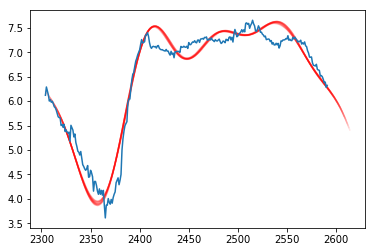

0.26 RMSE 


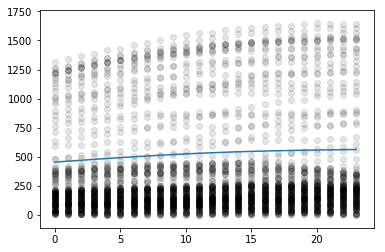

In [143]:
predict(starting_day=8)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


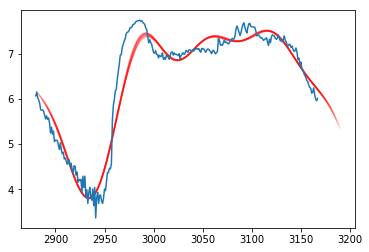

0.32 RMSE 


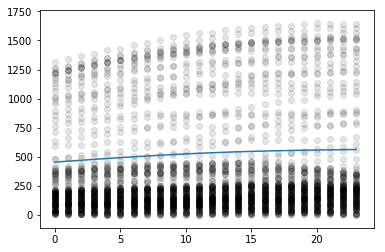

In [144]:
predict(starting_day=10)